# Generate `.sam` file with `move_table` and other tags

```python
%%bash
BAM_FILES="/v/volumes/nanopore/timin_uracil/oligos/timin20250417/basecall/20250430/bam/"
SORTED_BAM_FILES="/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/temp_bam/"
mkdir -p $SORTED_BAM_FILES

for BAM in ${BAM_FILES}*.bam; do
    BAM_BASE=$(basename "$BAM" .bam)
    samtools sort -n "${BAM_FILES}${BAM_BASE}.bam" -o "${SORTED_BAM_FILES}${BAM_BASE}.bam"
done
```

```python
import os
import pysam
from glob import glob

def filename_from_path(path):
    return path.split('/')[-1]

bam_files = glob("/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/temp_bam/*")
fastq_path = "/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/temp_fastq/"
os.mkdir(fastq_path)

for bam in bam_files:
    bam_file = pysam.AlignmentFile(bam, "rb", check_sq=False)
    with open(fastq_path+filename_from_path(bam)[:-3]+"fastq", "w") as fq_out:
        for read in bam_file:
            if read.is_unmapped:
                # Get the tags (it returns a list of tuples)
                tags = read.get_tags()
                # Convert tags to a string for the FASTQ header
                metadata = "\t".join(f"{tag}:{value}" for tag, value in tags)
                # Write the read to FASTQ format with metadata in the header
                fq_out.write(f"@{read.query_name} {metadata}\n")
                fq_out.write(f"{read.query_sequence}\n")
                fq_out.write("+\n")
                fq_out.write(f"{read.qual}\n")
```

```python
%%bash
minimap2=/v/scratch/tools/minimap2/minimap2

REF_SEQUENCE="references/reference_oligos.fasta" 
FASTQ_FILES="/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/temp_fastq/"
SAM_PATH="/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/dorado_mv_sam/"

for FASTQ in ${FASTQ_FILES}*.fastq; do
    FASTQ_BASE=$(basename "$FASTQ" .fastq)
    $minimap2 -ax map-ont -y -t 8 "$REF_SEQUENCE" "${FASTQ_FILES}${FASTQ_BASE}.fastq" > "${SAM_PATH}mapped_${FASTQ_BASE}.sam"
done
```

```python
%%bash
BAM_FILES="/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/temp_bam/"
FASTQ_FILES="/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/temp_fastq/"

rm -rf "${BAM_FILES}"
rm -rf "${FASTQ_FILES}"
```

---

In [1]:
from utils import *
from speedup import *

def check_sam_data(sam_data):
    result = np.array([
        [read['contig_name'], read['map_quality']] for read in sam_data 
    ])
    plt.figure(figsize=(6,4))
    plt.hist(result[:,0], bins=501, label=f'{len(np.unique(result[:,0]))}/500 reads')
    #plt.title('PCR dataset')
    plt.xlabel('Sequence number')
    plt.ylabel('Count')
    plt.legend(loc='center right')
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.hist(result[:,1], bins=max(result[:,1])-min(result[:,1]))
    #plt.title('dataset')
    plt.xlabel('MapQuality')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.show()

--- Warning! This version of speedup.py can cause errors. ---


In [2]:
path="/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/dorado_mv_sam/mapped_calls_2025-04-30_T12-47-22.sam"

In [3]:
sam_data = read_sam(path,
                    #max_deletion=10,
                    #max_insertion=10,
                    #min_MAPQ=30,
                    verbose=True
                   )

Loading files: 100%|██████████| 1/1 [01:16<00:00, 76.03s/file]

Number of reads stored: 859690
Number of reads dropped: 32564


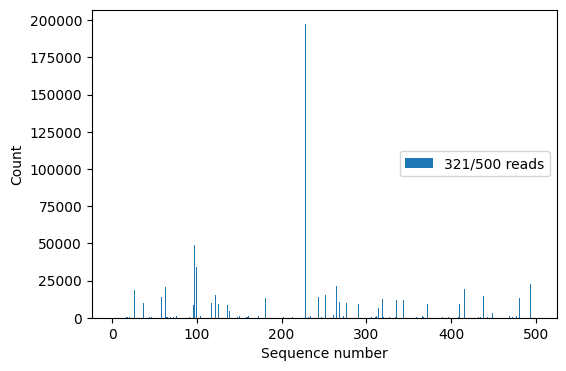

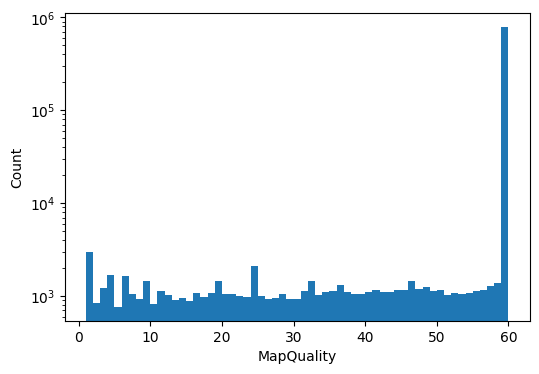

In [4]:
check_sam_data(sam_data)